# Import dependencies 

In [ ]:
import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

2025-10-22 00:23:02.933170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 00:23:02.993569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 00:23:04.436459: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set")
    except RuntimeError as e:
        print(e)


Memory growth set


In [3]:
tf.config.experimental.get_memory_info('GPU:0')


I0000 00:00:1761072845.798024   26520 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2085 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:02:00.0, compute capability: 8.6


{'current': 0, 'peak': 0}

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import gradio as gr


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# Load Images 

In [ ]:
# def load_images(folder, label, size=(244, 244)):
#     data = []
#     for filename in os.listdir(folder):
#         path = os.path.join(folder, filename)
#         img = cv2.imread(path)
#         if img is not None:
#             img = cv2.resize(img, size)
#             data.append((img, label))
#     return data

In [ ]:
# base_path = "/home/uppercase/Workspace/Lab Projects/ML/deepfake_detection"

# train_real = f"{base_path}/Dataset/Train/Real"
# train_fake = f"{base_path}/Dataset/Train/Fake"

# test_real = f"{base_path}/Dataset/Test/Real"
# test_fake = f"{base_path}/Dataset/Test/Fake"

# val_real = f"{base_path}/Dataset/Validation/Real"
# val_fake = f"{base_path}/Dataset/Validation/Fake"

In [11]:
base_path = "/home/uppercase/Workspace/Lab Projects/ML/deepfake_Dataset"

IMG_SIZE = (256,256)
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=f"{base_path}/Train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=f"{base_path}/Validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    directory=f"{base_path}/Test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb' ,
    shuffle=False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [14]:
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Train samples: 140002
Validation samples: 39428
Test samples: 10905


## Build Model 

In [ ]:
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(64, (3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(128, (3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])


model = tf.keras.models.load_model('../models/self_trained.h5')


In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy','AUC'])

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss ',
    patience=10,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks_list = [
    tensorboard_callback,
    model_checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback
]




In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks_list
)

/home/uppercase/Workspace/Lab Projects/ML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-10-22 00:27:46.205321: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d70d00248d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-22 00:27:46.205341: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-10-22 00:27:46.267147: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-22 00:27:46.632275: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


   1/4376 ━━━━━━━━━━━━━━━━━━━━ 15:20:38 13s/step - AUC: 0.9756 - accuracy: 0.9062 - loss: 0.1956

I0000 00:00:1761073076.803308   26946 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - AUC: 0.9827 - accuracy: 0.9364 - loss: 0.1689

2025-10-22 00:45:40.494711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_217', 20 bytes spill stores, 20 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.93008, saving model to best_model.h5


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1110s 251ms/step - AUC: 0.9839 - accuracy: 0.9390 - loss: 0.1626 - val_AUC: 0.9778 - val_accuracy: 0.9301 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 2/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - AUC: 0.9857 - accuracy: 0.9440 - loss: 0.1522
Epoch 2: val_accuracy did not improve from 0.93008
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1034s 236ms/step - AUC: 0.9863 - accuracy: 0.9444 - loss: 0.1486 - val_AUC: 0.9639 - val_accuracy: 0.9072 - val_loss: 0.2907 - learning_rate: 1.0000e-04
Epoch 3/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - AUC: 0.9878 - accuracy: 0.9478 - loss: 0.1398
Epoch 3: val_accuracy did not improve from 0.93008
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1032s 236ms/step - AUC: 0.9879 - accuracy: 0.9475 - loss: 0.1390 - val_AUC: 0.9765 - val_accuracy: 0.9233 - val_loss: 0.2015 - learning_rate: 1.0000e-04
Epoch 4/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - AUC: 0.9892 - accuracy: 0.9507 - loss: 0.1310
Epoch 4: val_accuracy did not impr

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1074s 245ms/step - AUC: 0.9900 - accuracy: 0.9530 - loss: 0.1254 - val_AUC: 0.9848 - val_accuracy: 0.9399 - val_loss: 0.1603 - learning_rate: 1.0000e-04
Epoch 6/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - AUC: 0.9905 - accuracy: 0.9549 - loss: 0.1210
Epoch 6: val_accuracy did not improve from 0.93994
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1035s 236ms/step - AUC: 0.9908 - accuracy: 0.9555 - loss: 0.1197 - val_AUC: 0.8954 - val_accuracy: 0.8066 - val_loss: 0.6290 - learning_rate: 1.0000e-04
Epoch 7/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - AUC: 0.9915 - accuracy: 0.9571 - loss: 0.1151
Epoch 7: val_accuracy improved from 0.93994 to 0.94151, saving model to best_model.h5


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1035s 236ms/step - AUC: 0.9915 - accuracy: 0.9572 - loss: 0.1150 - val_AUC: 0.9849 - val_accuracy: 0.9415 - val_loss: 0.1620 - learning_rate: 1.0000e-04
Epoch 8/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - AUC: 0.9919 - accuracy: 0.9581 - loss: 0.1115
Epoch 8: val_accuracy did not improve from 0.94151
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1029s 235ms/step - AUC: 0.9918 - accuracy: 0.9582 - loss: 0.1120 - val_AUC: 0.9831 - val_accuracy: 0.9358 - val_loss: 0.1724 - learning_rate: 1.0000e-04
Epoch 9/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - AUC: 0.9922 - accuracy: 0.9598 - loss: 0.1087
Epoch 9: val_accuracy did not improve from 0.94151
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1031s 236ms/step - AUC: 0.9924 - accuracy: 0.9601 - loss: 0.1081 - val_AUC: 0.9846 - val_accuracy: 0.9372 - val_loss: 0.1747 - learning_rate: 1.0000e-04
Epoch 10/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - AUC: 0.9924 - accuracy: 0.9613 - loss: 0.1072
Epoch 10: val_accuracy did not im

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1035s 237ms/step - AUC: 0.9941 - accuracy: 0.9649 - loss: 0.0935 - val_AUC: 0.9892 - val_accuracy: 0.9520 - val_loss: 0.1364 - learning_rate: 5.0000e-05
Epoch 12/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - AUC: 0.9940 - accuracy: 0.9659 - loss: 0.0935
Epoch 12: val_accuracy did not improve from 0.95204
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1025s 234ms/step - AUC: 0.9943 - accuracy: 0.9662 - loss: 0.0911 - val_AUC: 0.9852 - val_accuracy: 0.9432 - val_loss: 0.1571 - learning_rate: 5.0000e-05
Epoch 13/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - AUC: 0.9946 - accuracy: 0.9668 - loss: 0.0887
Epoch 13: val_accuracy improved from 0.95204 to 0.95255, saving model to best_model.h5


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1038s 237ms/step - AUC: 0.9945 - accuracy: 0.9665 - loss: 0.0904 - val_AUC: 0.9907 - val_accuracy: 0.9525 - val_loss: 0.1221 - learning_rate: 5.0000e-05
Epoch 14/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - AUC: 0.9945 - accuracy: 0.9662 - loss: 0.0904
Epoch 14: val_accuracy improved from 0.95255 to 0.95437, saving model to best_model.h5


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1028s 235ms/step - AUC: 0.9947 - accuracy: 0.9670 - loss: 0.0895 - val_AUC: 0.9905 - val_accuracy: 0.9544 - val_loss: 0.1244 - learning_rate: 5.0000e-05
Epoch 15/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - AUC: 0.9948 - accuracy: 0.9675 - loss: 0.0867
Epoch 15: val_accuracy did not improve from 0.95437
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1028s 235ms/step - AUC: 0.9947 - accuracy: 0.9668 - loss: 0.0882 - val_AUC: 0.9898 - val_accuracy: 0.9511 - val_loss: 0.1283 - learning_rate: 5.0000e-05
Epoch 16/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - AUC: 0.9949 - accuracy: 0.9670 - loss: 0.0869
Epoch 16: val_accuracy did not improve from 0.95437
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1026s 234ms/step - AUC: 0.9949 - accuracy: 0.9678 - loss: 0.0862 - val_AUC: 0.9890 - val_accuracy: 0.9522 - val_loss: 0.1365 - learning_rate: 5.0000e-05
Epoch 17/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - AUC: 0.9952 - accuracy: 0.9687 - loss: 0.0837
Epoch 17: val_accuracy did no


Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1020s 233ms/step - AUC: 0.9951 - accuracy: 0.9688 - loss: 0.0843 - val_AUC: 0.9903 - val_accuracy: 0.9548 - val_loss: 0.1283 - learning_rate: 5.0000e-05
Epoch 19/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - AUC: 0.9956 - accuracy: 0.9701 - loss: 0.0795
Epoch 19: val_accuracy improved from 0.95483 to 0.95754, saving model to best_model.h5


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1026s 234ms/step - AUC: 0.9957 - accuracy: 0.9703 - loss: 0.0792 - val_AUC: 0.9909 - val_accuracy: 0.9575 - val_loss: 0.1230 - learning_rate: 2.5000e-05
Epoch 20/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - AUC: 0.9957 - accuracy: 0.9715 - loss: 0.0780
Epoch 20: val_accuracy did not improve from 0.95754
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1026s 234ms/step - AUC: 0.9957 - accuracy: 0.9707 - loss: 0.0787 - val_AUC: 0.9905 - val_accuracy: 0.9567 - val_loss: 0.1227 - learning_rate: 2.5000e-05
Epoch 21/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - AUC: 0.9958 - accuracy: 0.9714 - loss: 0.0778
Epoch 21: val_accuracy improved from 0.95754 to 0.95772, saving model to best_model.h5


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1039s 237ms/step - AUC: 0.9957 - accuracy: 0.9712 - loss: 0.0784 - val_AUC: 0.9908 - val_accuracy: 0.9577 - val_loss: 0.1229 - learning_rate: 2.5000e-05
Epoch 22/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - AUC: 0.9959 - accuracy: 0.9716 - loss: 0.0776
Epoch 22: val_accuracy did not improve from 0.95772
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1018s 233ms/step - AUC: 0.9960 - accuracy: 0.9714 - loss: 0.0762 - val_AUC: 0.9905 - val_accuracy: 0.9574 - val_loss: 0.1269 - learning_rate: 2.5000e-05
Epoch 23/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - AUC: 0.9961 - accuracy: 0.9721 - loss: 0.0746
Epoch 23: val_accuracy improved from 0.95772 to 0.95871, saving model to best_model.h5



Epoch 23: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1020s 233ms/step - AUC: 0.9960 - accuracy: 0.9719 - loss: 0.0755 - val_AUC: 0.9907 - val_accuracy: 0.9587 - val_loss: 0.1237 - learning_rate: 2.5000e-05


In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/home/uppercase/Workspace/Lab Projects/ML/deepfake_Dataset/Test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10905 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


341/341 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 0.9130 - accuracy: 0.8271 - loss: 0.4347
Test Accuracy: 0.8271
Test AUC: 0.9130


In [ ]:
model.save("deepfake_detection_model.h5")

In [42]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes


341/341 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


In [43]:
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred_probs.shape)
print("Unique y_true:", np.unique(y_true))



y_true shape: (10905,)
y_pred shape: (10905, 2)
Unique y_true: [0 1]


              precision    recall  f1-score   support

        Real       0.78      0.92      0.84      5492
        Fake       0.90      0.74      0.81      5413

    accuracy                           0.83     10905
   macro avg       0.84      0.83      0.83     10905
weighted avg       0.84      0.83      0.83     10905

Confusion Matrix:
[[5036  456]
 [1429 3984]]


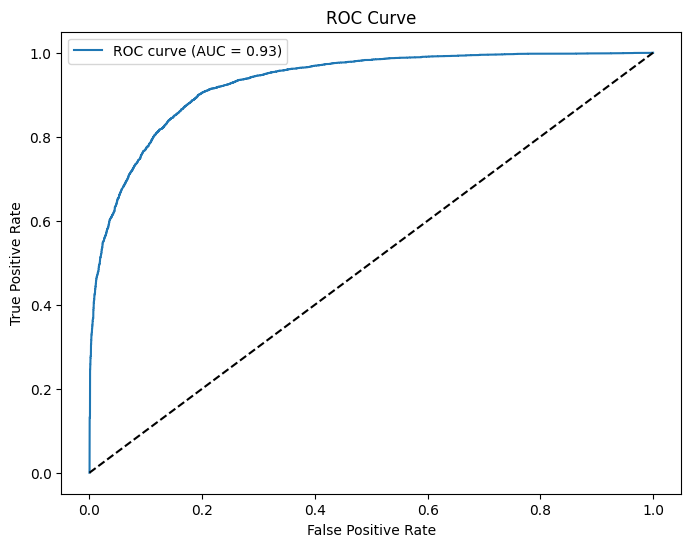

In [44]:

print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

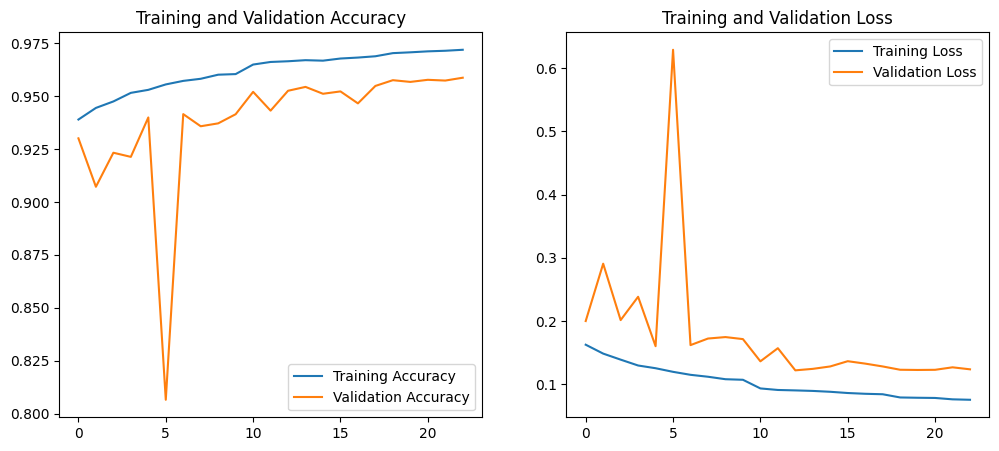

In [46]:
if history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
else:
    print("Skipping evaluation plots because the model was not trained.")


In [ ]:
def predict_image(img_path, threshold=0.5):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array, verbose=0)[0]
    prob_fake = float(pred[0])
    confidence = round(prob_fake * 100, 2)
    label = "Fake" if prob_fake >= threshold else "Real"

    return f"{label}"

In [ ]:
new_image_path = '/home/uppercase/Workspace/Lab Projects/ML/deepfake_Dataset/Test/Fake/fake_488.jpg'

result = predict_image(new_image_path)
print(f'The image is predicted as: {result}')

The image is predicted as: Fake


In [ ]:
new_image_path = '/home/uppercase/Workspace/Lab Projects/ML/deepfake_Dataset/Test/Real/real_897.jpg'

result = predict_image(new_image_path)
print(f'The image is predicted as: {result}')

The image is predicted as: Real


In [ ]:
interface = gr.Interface(fn=predict_image,
                         inputs=gr.Image(type="numpy", label="Upload or Capture Face Image"),
                         outputs="text",
                         title="Deepfake Detection",
                         description="Upload a face image to detect if it's a deepfake.")

interface.launch(share=True)